In [1]:
import os
import torch
import time
from tqdm import tqdm
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_tensor
from PIL import Image, ImageDraw
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

%pip install ultralytics




for dirname, _, filenames in os.walk("dataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Note: you may need to restart the kernel to use updated packages.


In [2]:
# define the directories paths
labels_dir = "pool-detection-dataset/dataset/labels"
images_dir = "pool-detection-dataset/dataset/images"
root_dir = "pool-detection-dataset/dataset"

In [3]:
def show_transformed_image(dataset, idx):
    """
    Display a transformed image from the dataset along with its bounding boxes.

    Args:
        dataset (pool_sat_Dataset): The dataset object.
        idx (int): The index of the image to display.

    Returns:
        None
    """
    image, target = dataset[idx]
    image = image.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    image = image.numpy()
    
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    print(target)
    for bbox in target['boxes']:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [4]:
train_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.RandomCrop(height=128, width=128, p=0.2),
    A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
    A.Rotate(limit=30, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

test_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Match training normalization
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [5]:
def parse_xml(xml_file):
    """ Parse the xml file and return the image data """
    with open(xml_file) as f:
        data = f.read()
    soup = BeautifulSoup(data, "xml")
    
    
    image_data = {
        "filename": soup.find("filename").text,
        "width": int(soup.find("size").find("width").text),
        "height": int(soup.find("size").find("height").text),
        "depth": int(soup.find("size").find("depth").text),
        "xmin": [],
        "ymin": [],
        "xmax": [],
        "ymax": [],
    }
    
    for obj in soup.find_all("object"):
        image_data["xmin"].append(int(obj.find("bndbox").find("xmin").text))
        image_data["ymin"].append(int(obj.find("bndbox").find("ymin").text))
        image_data["xmax"].append(int(obj.find("bndbox").find("xmax").text))
        image_data["ymax"].append(int(obj.find("bndbox").find("ymax").text))
        
    return image_data

In [6]:
all_images = []

for label_file in os.listdir(labels_dir):
    if label_file.endswith('.xml'):
        xml_path = os.path.join(labels_dir, label_file)
        image_data = parse_xml(xml_path)
        all_images.append(image_data)
        
df = pd.DataFrame(all_images)

df.head()

FeatureNotFound: Couldn't find a tree builder with the features you requested: xml. Do you need to install a parser library?

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2)

train_df.head(), test_df.head()

(    filename  width  height  depth           xmin            ymin  \
 155  114.PNG    220     189      3  [20, 55, 105]  [70, 103, 149]   
 55   173.PNG    222     250      3      [22, 134]      [101, 163]   
 120  124.PNG    175     192      3           [35]           [128]   
 102   67.PNG    168     146      3       [31, 97]        [91, 70]   
 151   73.PNG    195     164      3          [124]             [7]   
 
               xmax            ymax  
 155  [52, 82, 133]  [99, 129, 173]  
 55       [60, 155]      [133, 205]  
 120           [73]           [146]  
 102      [64, 131]       [122, 88]  
 151          [152]            [39]  ,
     filename  width  height  depth            xmin            ymin  \
 8    166.PNG    237     148      3            [45]            [41]   
 165  211.png    389     268      3           [153]           [247]   
 134  159.PNG    166     180      3        [49, 81]       [108, 57]   
 87   151.PNG    294     223      3  [31, 149, 209]  [36, 122, 16

In [9]:
class PoolDataset(Dataset):
    def __init__(self, dataframe, root_dir, transforms=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transforms = transforms
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # image loading
        img_path = os.path.join(self.root_dir, "images", self.dataframe.iloc[idx]["filename"])
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        
        # bounding boxes
        xmin = self.dataframe.iloc[idx]["xmin"]
        ymin = self.dataframe.iloc[idx]["ymin"]
        xmax = self.dataframe.iloc[idx]["xmax"]
        ymax = self.dataframe.iloc[idx]["ymax"]
        
        boxes = [[x, y, x2, y2] for x, y, x2, y2 in zip(xmin, ymin, xmax, ymax)]
        labels = [1] * len(boxes)  # assuming only one class (pool)
        
        target = {'boxes': boxes, 'labels': labels}
        
        if self.transforms:
            transformed = self.transforms(image=np.array(image), bboxes=target['boxes'], labels=target['labels'])
            image = transformed['image']
            target['boxes'] = transformed['bboxes']
            target['labels'] = transformed['labels']
        
        # Convert to tensor
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)
        
        return image, target

In [10]:

def collate_fn(batch): 
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

{'boxes': tensor([[ 84.5815,  40.6154, 107.7004,  54.1538],
        [ 53.0044, 110.3590,  82.3260, 119.7949]]), 'labels': tensor([1, 1])}


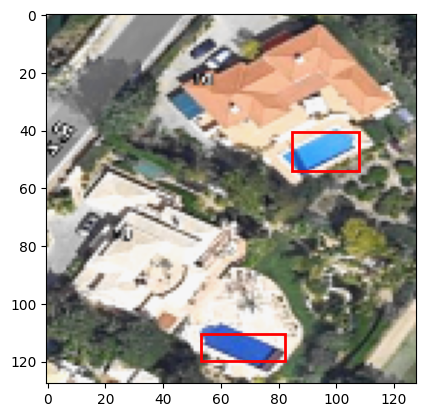

In [11]:
training_dataset = PoolDataset(df, root_dir, train_transforms)
test_dataset = PoolDataset(df, root_dir, test_transforms)


show_transformed_image(training_dataset, 5)

In [12]:
# initialize the dataloaders

train_loader = DataLoader(training_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_model(num_classes):
    # load a pre-trained model for classification
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [14]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    
    # Use tqdm for progress bar
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    
    for images, targets in progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        
        # Update progress bar
        progress_bar.set_postfix({"Loss": losses.item()})
    
    return total_loss / len(data_loader)

In [1]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    
    total_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        total_loss += sum(loss for loss in loss_dict.values())
    
    return total_loss / len(data_loader)

NameError: name 'torch' is not defined

In [ ]:
# Assuming you have 2 classes: background and pool
num_classes = 2

# Get the model
model = get_model(num_classes)
model.to(device)

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Train the model
num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()
    
    # Train for one epoch
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    
    # Evaluate on the test set
    test_loss = evaluate(model, test_loader, device)
    
    end_time = time.time()
    epoch_time = end_time - start_time
    
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Epoch Time: {epoch_time:.2f} seconds")
    print("-" * 40)


/home/francisco/IPVC/PROJECT_III/pool-detection-gis/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/francisco/IPVC/PROJECT_III/pool-detection-gis/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/1


Training:   0%|          | 0/43 [00:00<?, ?it/s]